In [36]:
import numpy as np
import pandas as pd
import scipy as sp 
import sys 
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri, globalenv

import os
os.environ["R_LIBS_USER"] = "/usr/local/lib/R/site-library"


# Importing other functions
import sys
sys.path.append(os.path.join('functions'))
from gamlass_main import *
from utils import *
from model_utils import *

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
# Load the necessary R packages
gamlss = importr('gamlss')
base = importr('base')


%reload_ext autoreload
%autoreload 2

# import warnings
# warnings.filterwarnings("ignore")

from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging
rpy2_logger.setLevel(logging.ERROR)


#### Creating dataset for testing the functions

In [37]:
import numpy as np
import pandas as pd

# Generate training data
np.random.seed(42)
n_train = 1000
age_train = np.random.randint(18, 80, n_train)
brain_volume_train = np.random.uniform(800, 1200, n_train)
lh_G_cingul_Post_dorsal_thickness_train = 2 + 0.05 * age_train + 0.01 * brain_volume_train + np.random.normal(0, 0.1, n_train)
df_train = pd.DataFrame({'age': age_train, 'brain_volume': brain_volume_train, 'lh_G_cingul_Post_dorsal_thickness': lh_G_cingul_Post_dorsal_thickness_train})

# Generate test data
n_test = 500
age_test = np.random.randint(18, 80, n_test)
brain_volume_test = np.random.uniform(800, 1200, n_test)
lh_G_cingul_Post_dorsal_thickness_test = 2 + 0.05 * age_test + 0.01 * brain_volume_test + np.random.normal(0, 0.1, n_test)

# Add outliers to the test data
outlier_indices = np.random.choice(n_test, size=50, replace=False)
lh_G_cingul_Post_dorsal_thickness_test[outlier_indices[:25]] += np.random.normal(0.5, 0.05, 25)  # Positive outliers
lh_G_cingul_Post_dorsal_thickness_test[outlier_indices[25:]] -= np.random.normal(0.5, 0.05, 25)  # Negative outliers

affected_test = np.zeros(n_test, dtype=int)
affected_test[outlier_indices] = 1

df_test = pd.DataFrame({'age': age_test, 'brain_volume': brain_volume_test, 'lh_G_cingul_Post_dorsal_thickness': lh_G_cingul_Post_dorsal_thickness_test, 'affected': affected_test})

In [38]:
df_train

,age,brain_volume,lh_G_cingul_Post_dorsal_thickness
0,56,950.695588,14.185225
1,69,1099.831320,16.400109
2,46,957.195780,13.732206
3,32,1131.665688,14.907132
4,60,1027.632588,15.315366
...,...,...,...
995,18,972.344837,12.635563
996,35,1158.685716,15.419180
997,49,828.512108,12.727066
998,64,1181.864012,16.968074


In [39]:
df_test

,age,brain_volume,lh_G_cingul_Post_dorsal_thickness,affected
0,35,1187.414933,15.481511,0
1,43,1041.454880,15.206369,1
2,23,830.791787,11.872489,1
3,21,830.233446,11.349869,0
4,61,1180.569288,17.147680,1
...,...,...,...,...
495,19,1121.521956,14.174338,0
496,77,854.859395,14.342399,0
497,41,1032.279634,14.474261,0
498,27,1002.203504,13.290263,0


#### Fitting models

In [40]:
# Defining x and y variables for GAMLSS
y_val = 'lh_G_cingul_Post_dorsal_thickness'
x_vals = ['age', 'brain_volume']
columns = x_vals.copy()
columns.extend([y_val])

In [41]:

# Selecting the columns for the training data
df_train = df_train.loc[:, columns]

# Create an instance of the Gamlss class
model_name = 'model_shash'
gamlss_model = Gamlss(model_name, x_vals, y_val)

# Fitting the model
gamlss_model.fit(
r_code="""
{model_name} <- gamlss({y_val} ~ pb(age) + brain_volume,
sigma.formula = ~ pb(age),
nu.formula = ~ 1,
tau.formula = ~ 1,
data = r_data,
family = SHASH(),
method = RS(100))
""",
data=df_train
)
# family = SHASH()

GAMLSS-RS iteration 1: Global Deviance = -1588.803 
GAMLSS-RS iteration 2: Global Deviance = -1624.254 
GAMLSS-RS iteration 3: Global Deviance = -1651.702 
GAMLSS-RS iteration 4: Global Deviance = -1671.766 
GAMLSS-RS iteration 5: Global Deviance = -1686.53 
GAMLSS-RS iteration 6: Global Deviance = -1697.04 
GAMLSS-RS iteration 7: Global Deviance = -1705.082 
GAMLSS-RS iteration 8: Global Deviance = -1711.261 
GAMLSS-RS iteration 9: Global Deviance = -1716.047 
GAMLSS-RS iteration 10: Global Deviance = -1719.817 
GAMLSS-RS iteration 11: Global Deviance = -1722.833 
GAMLSS-RS iteration 12: Global Deviance = -1725.254 
GAMLSS-RS iteration 13: Global Deviance = -1727.208 
GAMLSS-RS iteration 14: Global Deviance = -1728.795 
GAMLSS-RS iteration 15: Global Deviance = -1730.116 
GAMLSS-RS iteration 16: Global Deviance = -1731.226 
GAMLSS-RS iteration 17: Global Deviance = -1732.162 
GAMLSS-RS iteration 18: Global Deviance = -1732.946 
GAMLSS-RS iteration 19: Global Deviance = -1733.606 
GAML

In [42]:
list(robjects.r['model_shash'].rx2('parameters'))

['mu', 'sigma', 'nu', 'tau']

In [43]:
df_test1 = df_test.copy()
df_test1 = df_test1.loc[:, columns]

In [44]:
# Testing on the test dataset
predictions = gamlss_model.predict_all(df_test1, transform=True, verbose=True)
predictions


Family:  c("SHASH", "Sinh-Arcsinh") 
Fitting method: RS(100) 

Call:  gamlss(formula = lh_G_cingul_Post_dorsal_thickness ~  
    pb(age) + brain_volume, sigma.formula = ~pb(age),  
    nu.formula = ~1, tau.formula = ~1, family = SHASH(),  
    data = r_data, method = RS(100)) 

Mu Coefficients:
 (Intercept)       pb(age)  brain_volume  
     1.99539       0.04973       0.01002  
Sigma Coefficients:
(Intercept)      pb(age)  
 -2.3242129    0.0003773  
Nu Coefficients:
(Intercept)  
  -0.006297  
Tau Coefficients:
(Intercept)  
   -0.01832  

 Degrees of Freedom for the fit: 7.18 Residual Deg. of Freedom   992.8 
Global Deviance:     -1737.64 
            AIC:     -1723.28 
            SBC:     -1688.04 
Link functions:
mu_link: identity
sigma_link: log
nu_link: log
tau_link: log

Transformations applied:


,mu_pred,sigma_pred,nu_pred,tau_pred
1,15.633259,0.099135,0.993723,0.981847
2,14.568348,0.099393,0.993723,0.981847
3,11.464074,0.098753,0.993723,0.981847
4,11.359104,0.098689,0.993723,0.981847
5,16.856669,0.099997,0.993723,0.981847
...,...,...,...,...
496,14.178106,0.098626,0.993723,0.981847
497,14.389713,0.100569,0.993723,0.981847
498,14.377065,0.099328,0.993723,0.981847
499,13.380173,0.098880,0.993723,0.981847


In [45]:
predictions.describe()

,mu_pred,sigma_pred,nu_pred,tau_pred
count,500.000000,500.000000,5.000000e+02,5.000000e+02
mean,14.412330,0.099590,9.937229e-01,9.818467e-01
std,1.405540,0.000617,1.333602e-14,5.556675e-16
min,10.994955,0.098594,9.937229e-01,9.818467e-01
25%,13.443371,0.099071,9.937229e-01,9.818467e-01
50%,14.368432,0.099540,9.937229e-01,9.818467e-01
75%,15.375902,0.100137,9.937229e-01,9.818467e-01
max,17.819232,0.100642,9.937229e-01,9.818467e-01


In [51]:

# Calculate Z-scores for the test data
# DOing gamma her is not good as the code written is for SHASH and they have different paramerters in log link as their output
gamma_z_scores = gamlss_model.z_score(df_test1, func_name='SHASH')

print(gamma_z_scores)



Family:  c("SHASH", "Sinh-Arcsinh") 
Fitting method: RS(100) 

Call:  gamlss(formula = lh_G_cingul_Post_dorsal_thickness ~  
    pb(age) + brain_volume, sigma.formula = ~pb(age),  
    nu.formula = ~1, tau.formula = ~1, family = SHASH(),  
    data = r_data, method = RS(100)) 

Mu Coefficients:
 (Intercept)       pb(age)  brain_volume  
     1.99539       0.04973       0.01002  
Sigma Coefficients:
(Intercept)      pb(age)  
 -2.3242129    0.0003773  
Nu Coefficients:
(Intercept)  
  -0.006297  
Tau Coefficients:
(Intercept)  
   -0.01832  

 Degrees of Freedom for the fit: 7.18 Residual Deg. of Freedom   992.8 
Global Deviance:     -1737.64 
            AIC:     -1723.28 
            SBC:     -1688.04 
[-1.51467617e+00  6.12547706e+00  3.97601436e+00 -9.24839138e-02
  2.81356912e+00 -3.32228996e-01 -1.16973957e+00 -2.23207600e+00
  5.82541178e-01  1.58934832e+00  1.07471663e+00  7.26751079e-01
 -4.23320364e-01  8.51725242e-01  1.13413825e+00  1.53087913e-02
 -1.18948963e+00 -4.282328

In [52]:
test_z_scores = gamlss_model.z_score(df_test1,func_name='SHASH')


Family:  c("SHASH", "Sinh-Arcsinh") 
Fitting method: RS(100) 

Call:  

gamlss(formula = lh_G_cingul_Post_dorsal_thickness ~  
    pb(age) + brain_volume, sigma.formula = ~pb(age),  
    nu.formula = ~1, tau.formula = ~1, family = SHASH(),  
    data = r_data, method = RS(100)) 

Mu Coefficients:
 (Intercept)       pb(age)  brain_volume  
     1.99539       0.04973       0.01002  
Sigma Coefficients:
(Intercept)      pb(age)  
 -2.3242129    0.0003773  
Nu Coefficients:
(Intercept)  
  -0.006297  
Tau Coefficients:
(Intercept)  
   -0.01832  

 Degrees of Freedom for the fit: 7.18 Residual Deg. of Freedom   992.8 
Global Deviance:     -1737.64 
            AIC:     -1723.28 
            SBC:     -1688.04 


In [53]:
affected  = df_test.loc[:,'affected'].values



Family:  c("SHASH", "Sinh-Arcsinh") 
Fitting method: RS(100) 

Call:  gamlss(formula = lh_G_cingul_Post_dorsal_thickness ~  
    pb(age) + brain_volume, sigma.formula = ~pb(age),  
    nu.formula = ~1, tau.formula = ~1, family = SHASH(),  
    data = r_data, method = RS(100)) 

Mu Coefficients:
 (Intercept)       pb(age)  brain_volume  
     1.99539       0.04973       0.01002  
Sigma Coefficients:
(Intercept)      pb(age)  
 -2.3242129    0.0003773  
Nu Coefficients:
(Intercept)  
  -0.006297  
Tau Coefficients:
(Intercept)  
   -0.01832  

 Degrees of Freedom for the fit: 7.18 Residual Deg. of Freedom   992.8 
Global Deviance:     -1737.64 
            AIC:     -1723.28 
            SBC:     -1688.04 
zscore shape: 500, affected shape: 50
z score affected: [ 6.12547706  3.97601436  2.81356912 -5.4335358   6.99418317  6.36673724
  3.06969575 -5.60817275 -5.28414237 -4.83482958 -4.87088349 -4.92979172
  4.52941824 -5.1268665   4.88908941  3.8172411  -3.41445323  6.38161384
  4.2601100

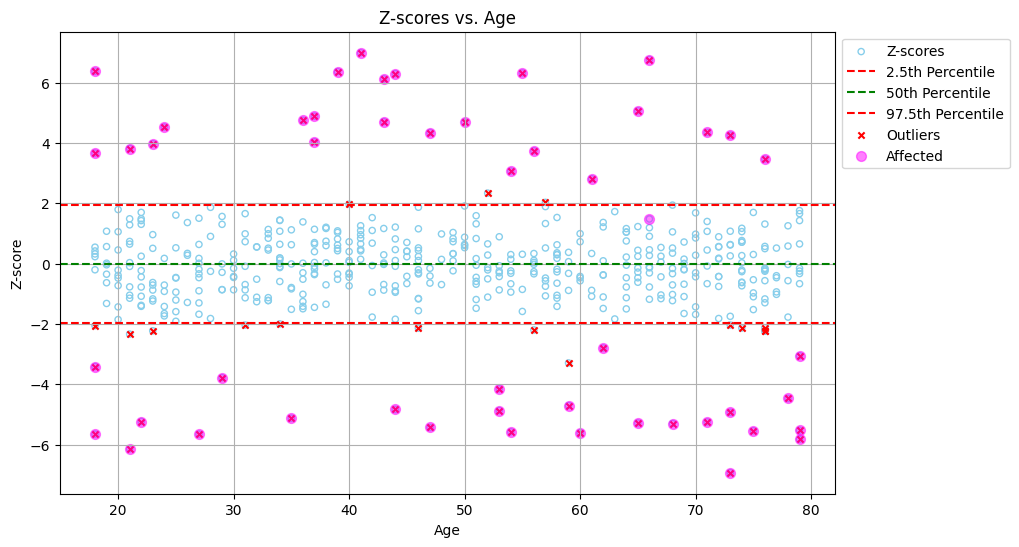

In [55]:
gamlss_model.plot_z_scores(df_test1, func_name = 'SHASH', affected=affected)


In [56]:
gamlss_model.centiles(df_test1, func_name = 'qSHASH')



Family:  c("SHASH", "Sinh-Arcsinh") 
Fitting method: RS(100) 

Call:  gamlss(formula = lh_G_cingul_Post_dorsal_thickness ~  
    pb(age) + brain_volume, sigma.formula = ~pb(age),  
    nu.formula = ~1, tau.formula = ~1, family = SHASH(),  
    data = r_data, method = RS(100)) 

Mu Coefficients:
 (Intercept)       pb(age)  brain_volume  
     1.99539       0.04973       0.01002  
Sigma Coefficients:
(Intercept)      pb(age)  
 -2.3242129    0.0003773  
Nu Coefficients:
(Intercept)  
  -0.006297  
Tau Coefficients:
(Intercept)  
   -0.01832  

 Degrees of Freedom for the fit: 7.18 Residual Deg. of Freedom   992.8 
Global Deviance:     -1737.64 
            AIC:     -1723.28 
            SBC:     -1688.04 


RRuntimeError: Error in qqSHASH(p, mu = mu_pred, sigma = sigma_pred, nu = nu_pred, tau = tau_pred) : 
  could not find function "qqSHASH"



Family:  c("SHASH", "Sinh-Arcsinh") 
Fitting method: RS(100) 

Call:  gamlss(formula = lh_G_cingul_Post_dorsal_thickness ~  
    pb(age) + brain_volume, sigma.formula = ~pb(age),  
    nu.formula = ~1, tau.formula = ~1, family = SHASH(),  
    data = r_data, method = RS(100)) 

Mu Coefficients:
 (Intercept)       pb(age)  brain_volume  
     1.99539       0.04973       0.01002  
Sigma Coefficients:
(Intercept)      pb(age)  
 -2.3242129    0.0003773  
Nu Coefficients:
(Intercept)  
  -0.006297  
Tau Coefficients:
(Intercept)  
   -0.01832  

 Degrees of Freedom for the fit: 7.18 Residual Deg. of Freedom   992.8 
Global Deviance:     -1737.64 
            AIC:     -1723.28 
            SBC:     -1688.04 


centile values: (1000, 3)
Centile list: [2.5, 50, 97.5]


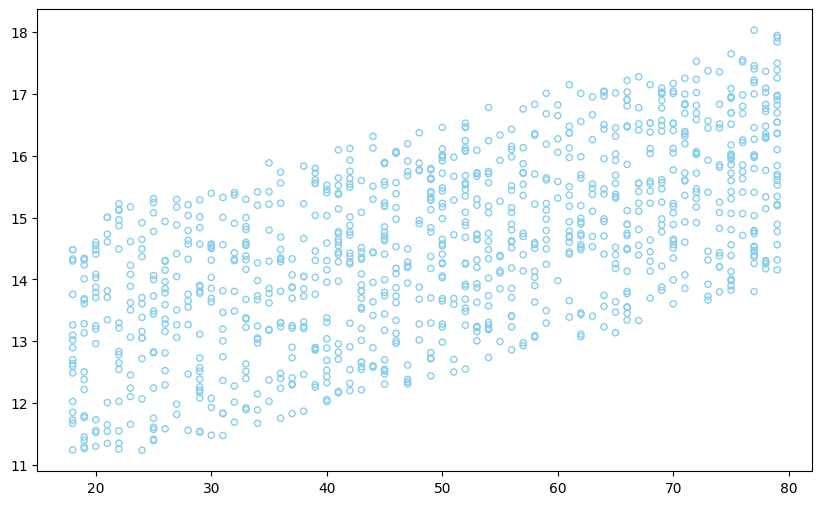

In [62]:

x, y, centile_values, centile_list = gamlss_model.plot_centiles(df_train, func_name = 'SHASH')


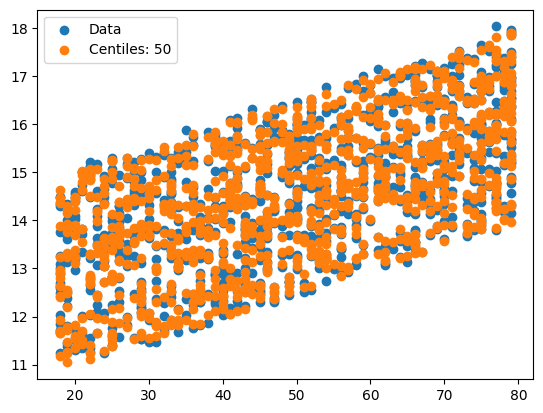

In [63]:
plt.scatter(x, y, label='Data')
# plt.scatter(x[0:20], centile_values[0:20,0], label=f'Centiles: {centile_list[0]}')
plt.scatter(x, centile_values[:,1], label=f'Centiles: {centile_list[1]}')
# plt.scatter(x, centile_values[:,2], label=f'Centiles: {centile_list[2]}')
plt.legend()


In [64]:
df = pd.DataFrame({'age': x, 'brain_vol': y, 'centile 2.5': centile_values[:,0], 'centile 50': centile_values[:,1], 'centile 97.5': centile_values[:,2]})
df

,age,brain_vol,centile 2.5,centile 50,centile 97.5
0,56,14.185225,14.107160,14.305007,14.506303
1,69,16.400109,16.247028,16.445778,16.647992
2,46,13.732206,13.676022,13.873208,14.073831
3,32,14.907132,14.729374,14.925666,15.125378
4,60,15.315366,15.076571,15.274691,15.476264
...,...,...,...,...,...
995,18,12.635563,12.438426,12.633835,12.832650
996,35,15.419180,15.148944,15.345425,15.545330
997,49,12.727066,12.535614,12.732996,12.933818
998,64,16.968074,16.820457,17.018854,17.220709


In [65]:
# Group by 'age' and calculate the mean for 'centile 2.5', 'centile 50', 'centile 97.5'
result_df = df.groupby('age')[['centile 2.5', 'centile 50', 'centile 97.5']].mean().reset_index()

# Rename the columns for clarity
result_df.columns = ['age', 'avg_centile 2.5', 'avg_centile 50', 'avg_centile 97.5']

print(result_df)

    age  avg_centile 2.5  avg_centile 50  avg_centile 97.5
0    18        12.703646       12.899055         13.097870
1    19        12.605506       12.800978         12.999857
2    20        13.143800       13.339335         13.538278
3    21        13.187431       13.383029         13.582036
4    22        13.096047       13.291707         13.490778
..  ...              ...             ...               ...
57   75        15.390441       15.589620         15.792271
58   76        16.025516       16.224768         16.427492
59   77        15.382304       15.581627         15.784425
60   78        15.691741       15.891137         16.094008
61   79        15.965972       16.165440         16.368385

[62 rows x 4 columns]


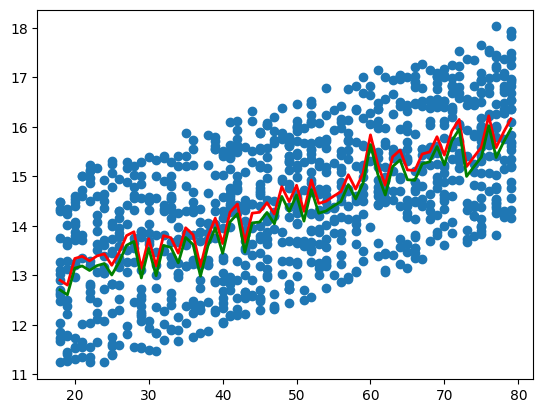

In [66]:
plt.scatter(x,y)
plt.plot(result_df['age'], result_df['avg_centile 50'], label='Centile 50', linewidth=2, color='red')
plt.plot(result_df['age'], result_df['avg_centile 2.5'], label='Centile 2.5', linewidth=2, color='green')


In [67]:
## To get the summary of the model
# model_summary = base.summary(robjects.r['model_shash'], type = "vcov", digits = 4)
# help_function = robjects.r('''help(summary)''')
# print(help_function)

model_summary = base.summary(robjects.r[model_name])
print(model_summary)

******************************************************************
Family:  c("SHASH", "Sinh-Arcsinh") 

Call:  gamlss(formula = lh_G_cingul_Post_dorsal_thickness ~  
    pb(age) + brain_volume, sigma.formula = ~pb(age),  
    nu.formula = ~1, tau.formula = ~1, family = SHASH(),  
    data = r_data, method = RS(100)) 

Fitting method: RS(100) 

------------------------------------------------------------------
Mu link function:  identity
Mu Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.995e+00  3.006e-02   66.38   <2e-16 ***
pb(age)      4.973e-02  1.776e-04  279.97   <2e-16 ***
brain_volume 1.002e-02  2.832e-05  353.78   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

------------------------------------------------------------------
Sigma link function:  log
Sigma Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.3242129  0.1052622 -22.080   <2e-16 ***
pb(age)      0.0003773  0.0012

In [68]:
bic = stats.BIC(robjects.r[model_name])[0]
print(bic)

-1688.041883767945


In [69]:
import numpy as np

def make_lss_SHASHo2(n_samples, interpolate_mu, interpolate_sigma, interpolate_nu, interpolate_tau):
    age = np.linspace(0, 100, n_samples)
    mu = np.interp(age, [0, 50, 100], interpolate_mu)
    sigma = np.interp(age, [0, 50, 100], interpolate_sigma)
    nu = np.interp(age, [0, 100], interpolate_nu)
    tau = np.interp(age, [0, 100], interpolate_tau)
    
    y = np.random.normal(loc=mu, scale=sigma)
    print("Length of y", len(y))
    return age.reshape(-1, 1), y

# Generate synthetic data
age, y = make_lss_SHASHo2(500,
                        interpolate_mu=[50, 52, 35],
                        interpolate_sigma=[2, 0.5, 2],
                        interpolate_nu=[-1.5, -1.5],
                        interpolate_tau=[1, 1])

Length of y 500


In [70]:
len(age), len(y)

(500, 500)

GAMLSS-RS iteration 1: Global Deviance = 1608.365 
GAMLSS-RS iteration 2: Global Deviance = 1574.023 
GAMLSS-RS iteration 3: Global Deviance = 1563.264 
GAMLSS-RS iteration 4: Global Deviance = 1555.289 
GAMLSS-RS iteration 5: Global Deviance = 1549.218 
GAMLSS-RS iteration 6: Global Deviance = 1544.626 
GAMLSS-RS iteration 7: Global Deviance = 1540.899 
GAMLSS-RS iteration 8: Global Deviance = 1538.016 
GAMLSS-RS iteration 9: Global Deviance = 1535.71 
GAMLSS-RS iteration 10: Global Deviance = 1533.809 
GAMLSS-RS iteration 11: Global Deviance = 1532.262 
GAMLSS-RS iteration 12: Global Deviance = 1531.003 
GAMLSS-RS iteration 13: Global Deviance = 1529.957 
GAMLSS-RS iteration 14: Global Deviance = 1529.081 
GAMLSS-RS iteration 15: Global Deviance = 1528.345 
GAMLSS-RS iteration 16: Global Deviance = 1527.724 
GAMLSS-RS iteration 17: Global Deviance = 1527.189 
GAMLSS-RS iteration 18: Global Deviance = 1526.735 
GAMLSS-RS iteration 19: Global Deviance = 1526.347 
GAMLSS-RS iteration 20

(array([  0.        ,   0.2004008 ,   0.4008016 ,   0.6012024 ,
          0.80160321,   1.00200401,   1.20240481,   1.40280561,
          1.60320641,   1.80360721,   2.00400802,   2.20440882,
          2.40480962,   2.60521042,   2.80561122,   3.00601202,
          3.20641283,   3.40681363,   3.60721443,   3.80761523,
          4.00801603,   4.20841683,   4.40881764,   4.60921844,
          4.80961924,   5.01002004,   5.21042084,   5.41082164,
          5.61122244,   5.81162325,   6.01202405,   6.21242485,
          6.41282565,   6.61322645,   6.81362725,   7.01402806,
          7.21442886,   7.41482966,   7.61523046,   7.81563126,
          8.01603206,   8.21643287,   8.41683367,   8.61723447,
          8.81763527,   9.01803607,   9.21843687,   9.41883768,
          9.61923848,   9.81963928,  10.02004008,  10.22044088,
         10.42084168,  10.62124248,  10.82164329,  11.02204409,
         11.22244489,  11.42284569,  11.62324649,  11.82364729,
         12.0240481 ,  12.2244489 ,  12.

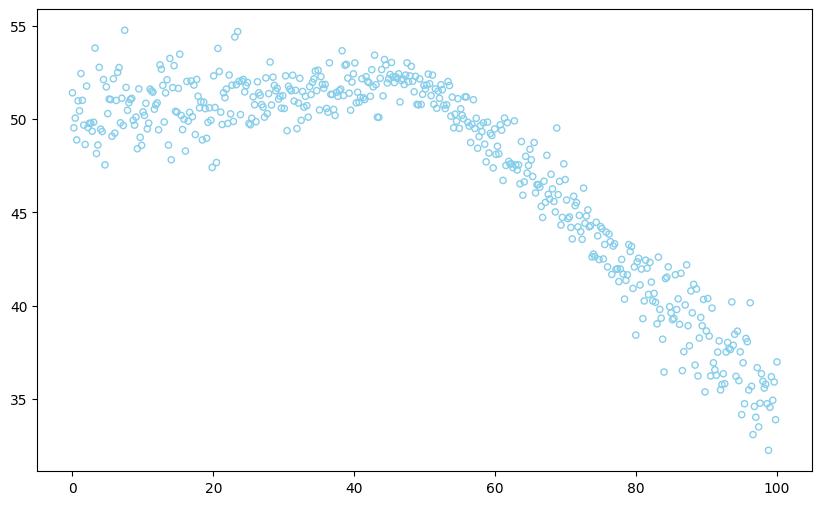

In [71]:

# Define the x and y variables for GAMLSS
y_val = 'y'
x_vals = ['age']

# Create a DataFrame
df = pd.DataFrame(np.column_stack((age.flatten(), y)), columns=['age', 'y'])

# Create an instance of the Gamlss class
model_name = 'model_shash'
gamlss_model = Gamlss(model_name, x_vals, y_val)

# Fit the model
gamlss_model.fit(
    r_code="""
    {model_name} <- gamlss({y_val} ~ pb({x_vals[0]}),
        sigma.formula = ~ pb({x_vals[0]}),
        nu.formula = ~ 1,
        tau.formula = ~ 1,
        data = r_data,
        family = SHASH(),
        method = RS(100))
    """,
    data=df
)

# Make predictions
predictions = gamlss_model.predict_all(df, verbose=True)

# Calculate centiles
centiles = gamlss_model.centiles(df, centile_list=[2.5, 50, 97.5], func_name='SHASH')

# Plot centiles
gamlss_model.plot_centiles(df, centile_list=[2.5, 50, 97.5], func_name='SHASH')


Family:  c("SHASH", "Sinh-Arcsinh") 
Fitting method: RS(100) 

Call:  gamlss(formula = y ~ pb(age), sigma.formula = ~pb(age),  
    nu.formula = ~1, tau.formula = ~1, family = SHASH(),  
    data = r_data, method = RS(100)) 

Mu Coefficients:
(Intercept)      pb(age)  
    54.5395      -0.1436  
Sigma Coefficients:
(Intercept)      pb(age)  
  0.2254724    0.0007508  
Nu Coefficients:
(Intercept)  
    0.02759  
Tau Coefficients:
(Intercept)  
   -0.03592  

 Degrees of Freedom for the fit: 17.71 Residual Deg. of Freedom   482.3 
Global Deviance:     1523.54 
            AIC:     1558.95 
            SBC:     1633.57 


centile values: (500, 3)
Centile list: [2.5, 50, 97.5]


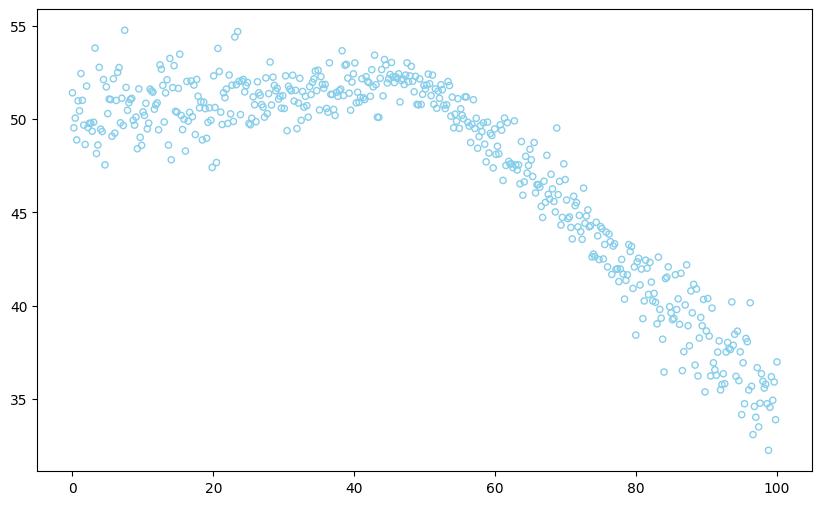

In [72]:
x, y, centile_values, centile_list = gamlss_model.plot_centiles(df, func_name = 'SHASH')


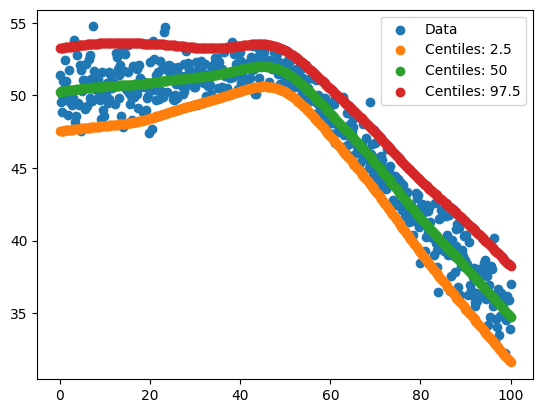

In [73]:
plt.scatter(x, y, label='Data')
plt.scatter(x, centile_values[:,0], label=f'Centiles: {centile_list[0]}')
plt.scatter(x, centile_values[:,1], label=f'Centiles: {centile_list[1]}')
plt.scatter(x, centile_values[:,2], label=f'Centiles: {centile_list[2]}')
plt.legend()


In [35]:
centile_values

array([[45.29443433, 49.72886076, 54.04987092],
       [45.33962234, 49.7470086 , 54.04167055],
       [45.38457927, 49.76513506, 54.03365314],
       ...,
       [33.02185321, 35.70937795, 38.32812872],
       [32.97492844, 35.65311088, 38.26275844],
       [32.92802483, 35.59688818, 38.19745511]])

In [ ]:
pd.DataFrame({'age': x, 'brain_vol': y, 'centile 2.5': centile_values[:,0], 'centile 50': centile_values[:,1], 'centile 97.5': centile_values[:,2]})

,age,brain_vol,centile 2.5,centile 50,centile 97.5
0,0.000000,51.436835,46.480420,50.038097,53.549720
1,0.200401,49.693470,46.504416,50.050626,53.550932
2,0.400802,48.740414,46.528370,50.063166,53.552205
3,0.601202,53.324716,46.552280,50.075716,53.553541
4,0.801603,48.340314,46.576145,50.088276,53.554944
...,...,...,...,...,...
495,99.198397,33.039366,31.612466,35.316296,38.972180
496,99.398798,35.745506,31.525768,35.247139,38.920337
497,99.599198,31.011938,31.438862,35.177913,38.868562
498,99.799599,34.884776,31.351756,35.108622,38.816857


### Comparing Models

Based on the data generating process we used to create the training dataset, model1 should perform better than model2. The reason is that model1 captures the true relationship between the target variable and the predictors, as it includes both age and sex in the model formula. On the other hand, model2 is misspecified because it omits the sex predictor, which has a significant effect on the target variable.

In [ ]:
# Defining x and y variables for GAMLSS
y_val = 'lh_G_cingul_Post_dorsal_thickness'
x_vals = ['age', 'brain_volume']
columns = x_vals.copy()
columns.extend([y_val])

In [ ]:
# This function gives us the flexibility on what we want to change and what we want to keep constant
# For example, we can keep the nu and tau formula fixed by removing it from this creat_model_func and in the next cell we can
# just change the other parameters or even change the way we want to input

def create_model_func(model_name, mu_formula, sigma_formula, nu_formula, tau_formula):
    def model_func(data):
        gamlss_model = Gamlss(model_name, x_vals, y_val)
        gamlss_model.fit(
            r_code=f"""
            {{model_name}} <- gamlss(
                {y_val} ~ {mu_formula},
                sigma.formula = ~ {sigma_formula},
                nu.formula = ~ {nu_formula},
                tau.formula = ~ {tau_formula},
                data = r_data,
                family = SHASH(),
                method = RS(400)
            )
            """,
            data=data
        )
        return gamlss_model
    return model_func


In [ ]:
# Define your model functions using the create_model_func helper
model1_func = create_model_func(
    model_name='model1',
    mu_formula='pb(age) + brain_volume',
    sigma_formula='pb(age)',
    nu_formula='1',
    tau_formula='1'
)

model2_func = create_model_func(
    model_name='model2',
    mu_formula='pb(age)',
    sigma_formula='pb(age)',
    nu_formula='1',
    tau_formula='1'
)

In [ ]:
# Compare the models
results_df, summary = compare_models(model1_func, model2_func, data=df_train)

GAMLSS-RS iteration 1: Global Deviance = -1674.737 
GAMLSS-RS iteration 2: Global Deviance = -1710.495 
GAMLSS-RS iteration 3: Global Deviance = -1734.379 
GAMLSS-RS iteration 4: Global Deviance = -1752.436 
GAMLSS-RS iteration 5: Global Deviance = -1765.407 
GAMLSS-RS iteration 6: Global Deviance = -1775.29 
GAMLSS-RS iteration 7: Global Deviance = -1782.757 
GAMLSS-RS iteration 8: Global Deviance = -1788.57 
GAMLSS-RS iteration 9: Global Deviance = -1793.117 
GAMLSS-RS iteration 10: Global Deviance = -1796.753 
GAMLSS-RS iteration 11: Global Deviance = -1799.679 
GAMLSS-RS iteration 12: Global Deviance = -1802.023 
GAMLSS-RS iteration 13: Global Deviance = -1803.936 
GAMLSS-RS iteration 14: Global Deviance = -1805.499 
GAMLSS-RS iteration 15: Global Deviance = -1806.791 
GAMLSS-RS iteration 16: Global Deviance = -1807.873 
GAMLSS-RS iteration 17: Global Deviance = -1808.773 
GAMLSS-RS iteration 18: Global Deviance = -1809.534 
GAMLSS-RS iteration 19: Global Deviance = -1810.171 
GAML

In [ ]:
# Print the comparison results
print("Model Comparison Results:")
print(results_df)

Model Comparison Results:
                AIC          BIC  Converged
Model                                      
model1 -1799.533561 -1764.310473       True
model2  2994.244430  3023.717252      False


In [ ]:
# Print the summary of the best models
print("Summary of Best Models:")
print(summary)

Summary of Best Models:
{'Best_Model_AIC': 'model1', 'AIC_Diff': 4793.777991369328, 'Best_Model_BIC': 'model1', 'BIC_Diff': 4788.0277244458775}
